In [ ]:
import numpy as np
import pandas as pd

In [ ]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [ ]:
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [ ]:
match.shape

(756, 18)

In [ ]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [ ]:
def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]

    if temp_df.empty:
        return temp_df, None  # Return empty DataFrame if no data is available for the match

    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100, 1)
    temp_df['win'] = np.round(result.T[1]*100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0]+1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target


In [ ]:
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

In [ ]:
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [ ]:
total_score_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [ ]:
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [ ]:
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [ ]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [ ]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [ ]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [ ]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [ ]:
match_df.shape

(641, 20)

In [ ]:
match_df = match_df[match_df['dl_applied'] == 0]

In [ ]:
match_df = match_df[['match_id','city','winner','total_runs']]

In [ ]:
delivery_df = match_df.merge(delivery,on='match_id')

In [ ]:
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [ ]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [ ]:
# Fill non-finite values with 0
delivery_df['total_runs_y'] = delivery_df['total_runs_y'].fillna(0)

# Convert the data type of the column to integer
delivery_df['total_runs_y'] = delivery_df['total_runs_y'].astype(int)


In [ ]:
# Convert the data type of the column to numeric (assuming it's integer)
delivery_df['total_runs_y'] = delivery_df['total_runs_y'].astype(int)

# Now you can calculate the cumulative sum
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()


In [ ]:
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

In [ ]:
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

In [ ]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,206,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,204,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,200,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,0,4
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-2,3
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-3,2
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-5,1


In [ ]:
# Replace non-numeric values with 0 in 'player_dismissed'
delivery_df['player_dismissed'] = pd.to_numeric(delivery_df['player_dismissed'], errors='coerce').fillna(0)

# Convert 'player_dismissed' to int
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(int)

# Group by 'match_id' and sum the 'player_dismissed' column to count wickets
wickets_count = delivery_df.groupby('match_id')['player_dismissed'].sum()

# Calculate remaining wickets by subtracting wickets count from total possible wickets (10)
delivery_df['wickets'] = 10 - delivery_df['match_id'].map(wickets_count)

# Display the DataFrame
print(delivery_df.head())


     match_id       city               winner  total_runs_x  inning  \
125         1  Hyderabad  Sunrisers Hyderabad           207       2   
126         1  Hyderabad  Sunrisers Hyderabad           207       2   
127         1  Hyderabad  Sunrisers Hyderabad           207       2   
128         1  Hyderabad  Sunrisers Hyderabad           207       2   
129         1  Hyderabad  Sunrisers Hyderabad           207       2   

                    batting_team         bowling_team  over  ball  \
125  Royal Challengers Bangalore  Sunrisers Hyderabad     1     1   
126  Royal Challengers Bangalore  Sunrisers Hyderabad     1     2   
127  Royal Challengers Bangalore  Sunrisers Hyderabad     1     3   
128  Royal Challengers Bangalore  Sunrisers Hyderabad     1     4   
129  Royal Challengers Bangalore  Sunrisers Hyderabad     1     5   

           batsman  ... batsman_runs extra_runs  total_runs_y  \
125       CH Gayle  ...            1          0             1   
126  Mandeep Singh  ...     

In [ ]:
# Fill missing values in 'player_dismissed' with 0 and convert to int
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0).astype(int)

# Group by 'match_id' and sum the 'player_dismissed' column to count wickets
wickets_count = delivery_df.groupby('match_id')['player_dismissed'].sum()

# Calculate remaining wickets by subtracting wickets count from total possible wickets (10)
delivery_df['wickets'] = 10 - delivery_df['match_id'].map(wickets_count)

# Display the DataFrame
print(delivery_df.head())


     match_id       city               winner  total_runs_x  inning  \
125         1  Hyderabad  Sunrisers Hyderabad           207       2   
126         1  Hyderabad  Sunrisers Hyderabad           207       2   
127         1  Hyderabad  Sunrisers Hyderabad           207       2   
128         1  Hyderabad  Sunrisers Hyderabad           207       2   
129         1  Hyderabad  Sunrisers Hyderabad           207       2   

                    batting_team         bowling_team  over  ball  \
125  Royal Challengers Bangalore  Sunrisers Hyderabad     1     1   
126  Royal Challengers Bangalore  Sunrisers Hyderabad     1     2   
127  Royal Challengers Bangalore  Sunrisers Hyderabad     1     3   
128  Royal Challengers Bangalore  Sunrisers Hyderabad     1     4   
129  Royal Challengers Bangalore  Sunrisers Hyderabad     1     5   

           batsman  ... batsman_runs extra_runs  total_runs_y  \
125       CH Gayle  ...            1          0             1   
126  Mandeep Singh  ...     

In [ ]:
# Fill missing values in 'player_dismissed' with 0 and convert to int
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0).astype(int)

# Group by 'match_id' and sum the 'player_dismissed' column to count wickets
wickets_count = delivery_df.groupby('match_id')['player_dismissed'].sum()

# Calculate remaining wickets by subtracting wickets count from total possible wickets (10)
delivery_df['wickets'] = 10 - delivery_df['match_id'].map(wickets_count)


In [ ]:
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,206,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,204,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,200,115,10


In [ ]:
# crr = runs/overs
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])

In [ ]:
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

In [ ]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [ ]:
delivery_df['result'] = delivery_df.apply(result,axis=1)

In [ ]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','winner','wickets','total_runs_x','crr','rrr','result']]

In [ ]:
final_df = final_df.sample(final_df.shape[0])

In [ ]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
78960,Royal Challengers Bangalore,Mumbai Indians,Mumbai,169,97,10,194,6.521739,10.453608,0


In [ ]:
final_df.dropna(inplace=True)

In [ ]:
final_df = final_df[final_df['balls_left'] != 0]

In [ ]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
X_train

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr
13105,Deccan Chargers,Chennai Super Kings,Chennai,139,106,10,144,2.142857,7.867925
84684,Kings XI Punjab,Royal Challengers Bangalore,Chandigarh,177,105,10,190,5.200000,10.114286
25956,Royal Challengers Bangalore,Mumbai Indians,Johannesburg,106,94,10,149,9.923077,6.765957
130434,Kings XI Punjab,Rajasthan Royals,Jaipur,69,34,10,161,6.418605,12.176471
22520,Delhi Daredevils,Royal Challengers Bangalore,Port Elizabeth,124,97,10,149,6.521739,7.670103
...,...,...,...,...,...,...,...,...,...
124514,Royal Challengers Bangalore,Mumbai Indians,Mumbai,205,103,10,230,8.823529,11.941748
40825,Royal Challengers Bangalore,Kings XI Punjab,Chandigarh,80,42,10,181,7.769231,11.428571
64666,Chennai Super Kings,Kings XI Punjab,Chennai,154,114,10,156,2.000000,8.105263
124034,Chennai Super Kings,Kings XI Punjab,Mohali,185,113,10,198,11.142857,9.823009


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [ ]:
pipe.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7912958161048427

In [ ]:
pipe.predict_proba(X_test)[10]

array([0.83816821, 0.16183179])

In [ ]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))


In [ ]:
def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team', 'bowling_team','winner', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]

    if temp_df.empty:
        return temp_df, None  # Return empty DataFrame if no data is available for the match

    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100, 1)
    temp_df['win'] = np.round(result.T[1]*100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0]+1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target


In [ ]:

temp_df,target = match_progression(delivery_df,18,pipe)
temp_df

Target- 168


,end_of_over,runs_after_over,wickets_in_over,lose,win
2303,1,6,0,44.2,55.8
2309,2,13,0,31.8,68.2
2315,3,2,0,44.6,55.4
2321,4,7,0,46.3,53.7
2327,5,6,0,50.1,49.9
2333,6,15,0,35.6,64.4
2339,7,3,0,45.3,54.7
2345,8,9,0,43.1,56.9
2351,9,10,0,38.9,61.1
2358,10,13,0,29.5,70.5


Text(0.5, 1.0, 'Target-168')

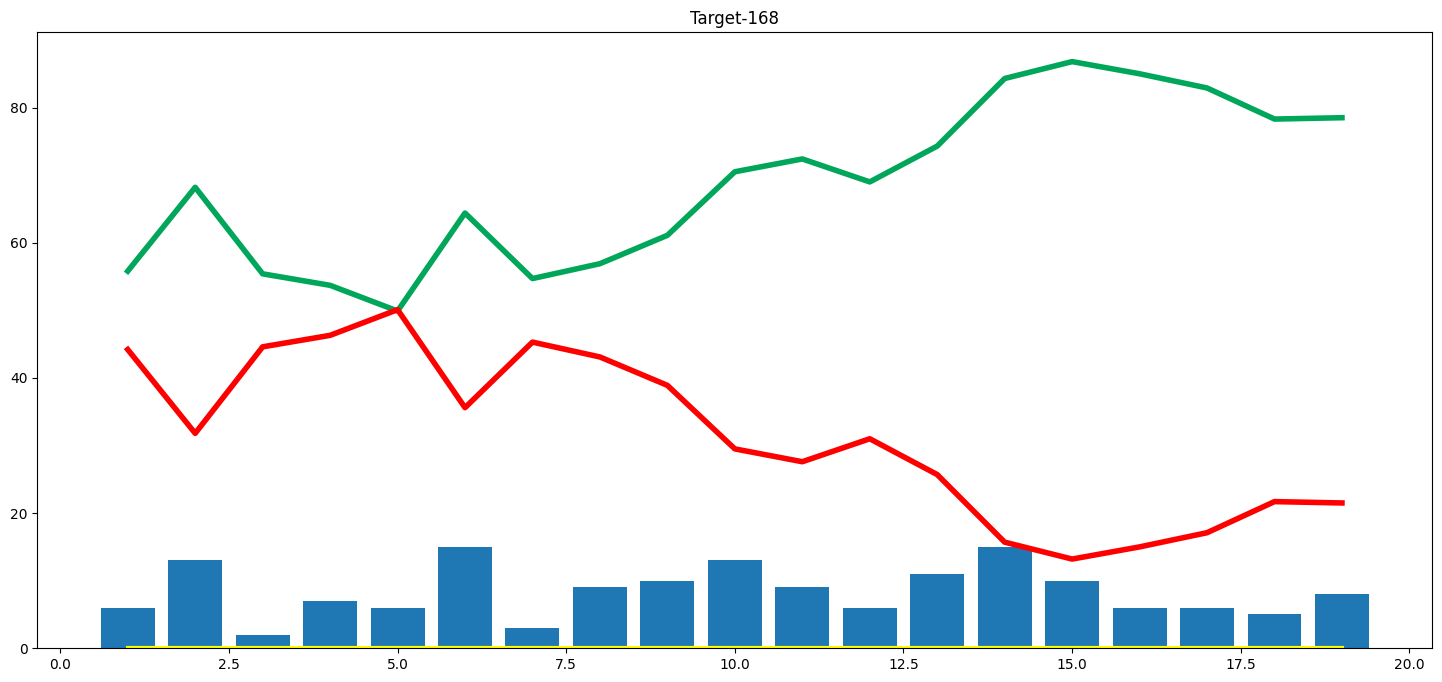

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [ ]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [ ]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [ ]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

In [ ]:
# Check the first few rows of the DataFrame to verify its content and indexing
print(matches_df.head())



   id    Season       city        date                        team1  \
0   1  IPL-2017  Hyderabad  05-04-2017          Sunrisers Hyderabad   
1   2  IPL-2017       Pune  06-04-2017               Mumbai Indians   
2   3  IPL-2017     Rajkot  07-04-2017                Gujarat Lions   
3   4  IPL-2017     Indore  08-04-2017       Rising Pune Supergiant   
4   5  IPL-2017  Bangalore  08-04-2017  Royal Challengers Bangalore   

                         team2                  toss_winner toss_decision  \
0  Royal Challengers Bangalore  Royal Challengers Bangalore         field   
1       Rising Pune Supergiant       Rising Pune Supergiant         field   
2        Kolkata Knight Riders        Kolkata Knight Riders         field   
3              Kings XI Punjab              Kings XI Punjab         field   
4             Delhi Daredevils  Royal Challengers Bangalore           bat   

   result  dl_applied                       winner  win_by_runs  \
0  normal           0          Sunrisers Hy

In [ ]:


# Check the index of the DataFrame
print(matches_df.index)




RangeIndex(start=0, stop=756, step=1)


In [ ]:

# Check if the match ID you're trying to predict exists in the DataFrame
print(match_id_to_predict in matches_df.index)


True


In [ ]:
def calculate_winning_probability(match_id, matches_df):
    # Step 1: Check if the match ID exists in the dataset
    if match_id in matches_df.index:
        # Step 2: Retrieve relevant information for the specified match
        match_data = matches_df.loc[match_id]

        # Step 3: Calculate winning probability based on historical data
        total_matches = len(matches_df)
        team1_wins = len(matches_df[matches_df['winner'] == match_data['team1']])
        team2_wins = len(matches_df[matches_df['winner'] == match_data['team2']])

        team1_win_prob = team1_wins / total_matches
        team2_win_prob = team2_wins / total_matches

        return {
            match_data['team1']: team1_win_prob,
            match_data['team2']: team2_win_prob
        }
    else:
        return "Match ID not found in the dataset."

# Example: Calculate winning probability for a specific match
match_id_to_predict = 4  # Change this to the match ID you want to calculate the winning probability for

# Ensure match_id_to_predict exists in your DataFrame index
if match_id_to_predict in matches_df.index:
    winning_probabilities = calculate_winning_probability(match_id_to_predict, matches_df)
    print("Winning probabilities for match {}:".format(match_id_to_predict))
    for team, prob in winning_probabilities.items():
        print("- {}: {:.2f}%".format(team, prob * 100))
else:
    print("Match ID {} not found in the dataset.".format(match_id_to_predict))


Winning probabilities for match 4:
- Royal Challengers Bangalore: 11.11%
- Delhi Daredevils: 8.86%


In [ ]:
def predict_match_winner(match_id, matches_df):
    # Step 1: Check if the match ID exists in the dataset
    if match_id in matches_df.index:
        # Step 2: Retrieve the winner of the specified match
        winner = matches_df.loc[match_id, 'winner']
        return winner
    else:
        return "Match ID not found in the dataset."

# Example: Predict the winner of a specific match
match_id_to_predict = 4  # Change this to the match ID you want to predict the winner for

# Ensure match_id_to_predict exists in your DataFrame index
if match_id_to_predict in matches_df.index:
    predicted_winner = predict_match_winner(match_id_to_predict, matches_df)
    print("Predicted winner of match {}: {}".format(match_id_to_predict, predicted_winner))
else:
    print("Match ID {} not found in the dataset.".format(match_id_to_predict))


Predicted winner of match 4: Royal Challengers Bangalore


In [ ]:
import pandas as pd

# Load your dataset into a DataFrame named matches_df
matches_df = pd.read_csv('matches.csv')  # Replace 'your_dataset.csv' with the actual filename of your dataset

# Now you can use the provided code to find the IPL trophy winner for a specific season
def find_trophy_winner(ipl_season, matches_df):
    # Convert ipl_season to string to ensure correct matching
    ipl_season_str = str(ipl_season)

    # Filter matches for the specified IPL season
    season_matches = matches_df[matches_df['Season'].str.strip() == ipl_season_str]

    # Check if any matches are found for the specified season
    if not season_matches.empty:
        # Find the final match of the season
        final_match = season_matches.iloc[-1]

        # Get the winner of the final match
        trophy_winner = final_match['winner']

        return trophy_winner
    else:
        return "No matches found for the {} season.".format(ipl_season_str)

# Example: Find the IPL trophy winner for a specific season
ipl_season_to_check = 'IPL-2008'  # Change this to the IPL season you want to check

# Ensure the IPL season exists in your DataFrame
if str(ipl_season_to_check).strip() in matches_df['Season'].str.strip().unique():
    trophy_winner = find_trophy_winner(ipl_season_to_check, matches_df)
    print("The winner of the IPL trophy for the {} season is: {}".format(ipl_season_to_check, trophy_winner))
else:
    print("No matches found for the {} season.".format(ipl_season_to_check))


The winner of the IPL trophy for the IPL-2008 season is: Rajasthan Royals


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the previous matches dataset into a DataFrame
previous_matches_df = pd.read_csv('matches.csv')  # Replace 'matches.csv' with your dataset filename

# Extract year from 'Season' column and convert to integer
previous_matches_df['Season'] = previous_matches_df['Season'].str.extract('(\d+)').astype(int)

# Filter data for IPL seasons 2008 to 2019
previous_matches_df = previous_matches_df[(previous_matches_df['Season'] >= 2008) & (previous_matches_df['Season'] <= 2019)]

# Define features and target variable
features = ['team1', 'team2', 'toss_winner', 'toss_decision', 'venue']
target = 'winner'

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['team1', 'team2', 'toss_winner', 'toss_decision', 'venue']),  # Most frequent imputation for categorical features
        ('onehot', OneHotEncoder(), ['team1', 'team2', 'toss_winner', 'toss_decision'])  # One-hot encode categorical features
    ],
    remainder='drop'  # Drop any remaining columns
)

# Define the pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

try:
    # Train the model
    pipeline.fit(previous_matches_df[features], previous_matches_df[target])

    # Load the upcoming fixtures dataset into a DataFrame
    upcoming_fixtures_df = pd.read_csv('IPL_2021_Timetable.csv')  # Replace 'IPL_2021_Timetable.csv' with your dataset filename

    # Preprocess the upcoming fixtures data
    X_upcoming_fixtures = upcoming_fixtures_df[features]  # Extract relevant features
    X_upcoming_fixtures_processed = preprocessor.transform(X_upcoming_fixtures)  # Apply preprocessing

    # Predict the winner for the upcoming season
    predicted_winner = pipeline.predict(X_upcoming_fixtures_processed)
    print("Predicted winner for the upcoming season:", predicted_winner)
except Exception as e:
    print("Error:", e)


Error: For a sparse output, all columns should be a numeric or convertible to a numeric.
